In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats


import random
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

np.random.seed(12345)
plt.rc('figure',figsize=(15,5))
np.set_printoptions(precision=4,suppress=True)

Mounted at /content/drive


In [2]:
# Mapping for party colors and regions
party_color_map = {
    'Republican': 'Red',
    'Democratic': 'Blue',
    'Libertarian': 'Yellow',
    'Other': 'Grey'
}

region_color_map = {
    'South': 'darkred',
    'Midwest': 'peru',
    'West': 'darkorange',
    'Northeast': 'deepskyblue'
}

In [3]:
# The country_voting dataset includes the number of votes received by each political party in every state, spanning from 1976 to 2020.
country_voting=pd.read_csv('/content/drive/MyDrive/CP project/Project/Cleaned Datasets/Votes Party per state 1976-2020.csv',
                           index_col=['Year', 'State'])
country_voting.head()

State Initials  Democratic  Libertarian   Other  Republican  \
Year State                                                                    
1976 ALABAMA                AL      659170         1481   18129      504070   
     ALASKA                 AK       44058         6785    1176       71555   
     ARIZONA                AZ      295602         7647   20828      418642   
     ARKANSAS               AR      498604            0    1028      267903   
     CALIFORNIA             CA     3742284            0  179242     3882244   

                Region      Winner  
Year State                          
1976 ALABAMA     South  Democratic  
     ALASKA       West  Republican  
     ARIZONA      West  Republican  
     ARKANSAS    South  Democratic  
     CALIFORNIA   West  Republican

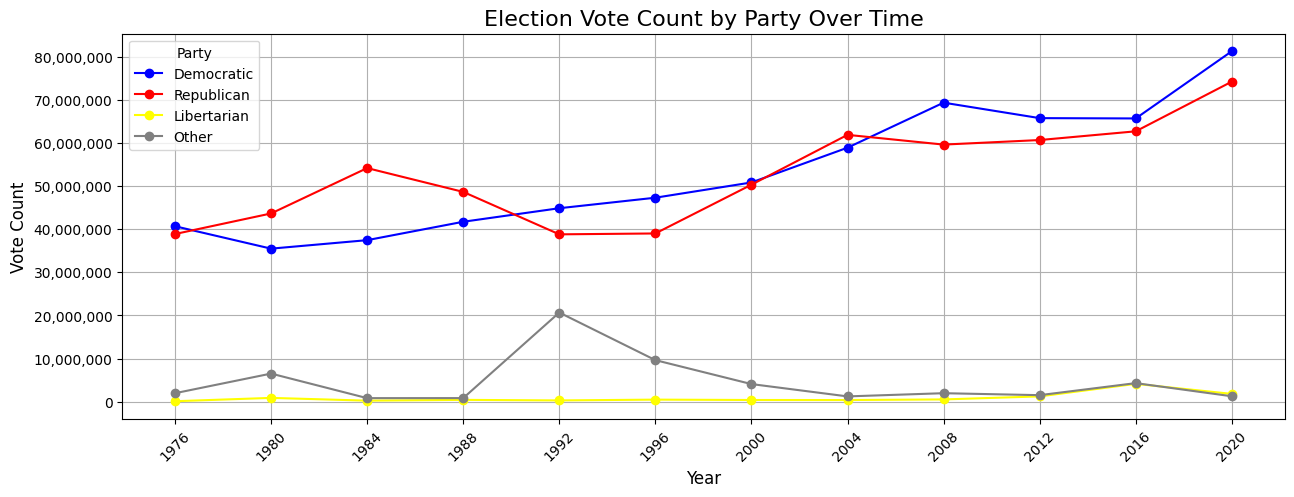

<Figure size 1500x500 with 0 Axes>

In [4]:
#Let's create yearly data
country_voting_year = country_voting.groupby('Year').sum(numeric_only=True).reset_index()

# Plotting the vote shares for each party over time
ax = country_voting_year[['Democratic', 'Republican', 'Libertarian', 'Other']].plot(
    figsize=(15, 5),
    color=[party_color_map['Democratic'], party_color_map['Republican'],  # we utilize the previoysly defined color map for parties
           party_color_map['Libertarian'], party_color_map['Other']],
    linestyle='-',
    marker='o',
    markersize=6
)

# We do this in order to prevent scientific notation on the y-axis
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.title('Election Vote Count by Party Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Vote Count', fontsize=12)

plt.xticks(ticks=country_voting_year.index, labels=country_voting_year['Year'], rotation=45)

# Adding the legend with titles for the parties
plt.legend(title='Party', labels=['Democratic', 'Republican', 'Libertarian', 'Other'])

# Display the plot
plt.grid(True)
plt.show()
output_file = 'election_vote_count_by_party.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
output_file = 'election_vote_count_by_party.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')

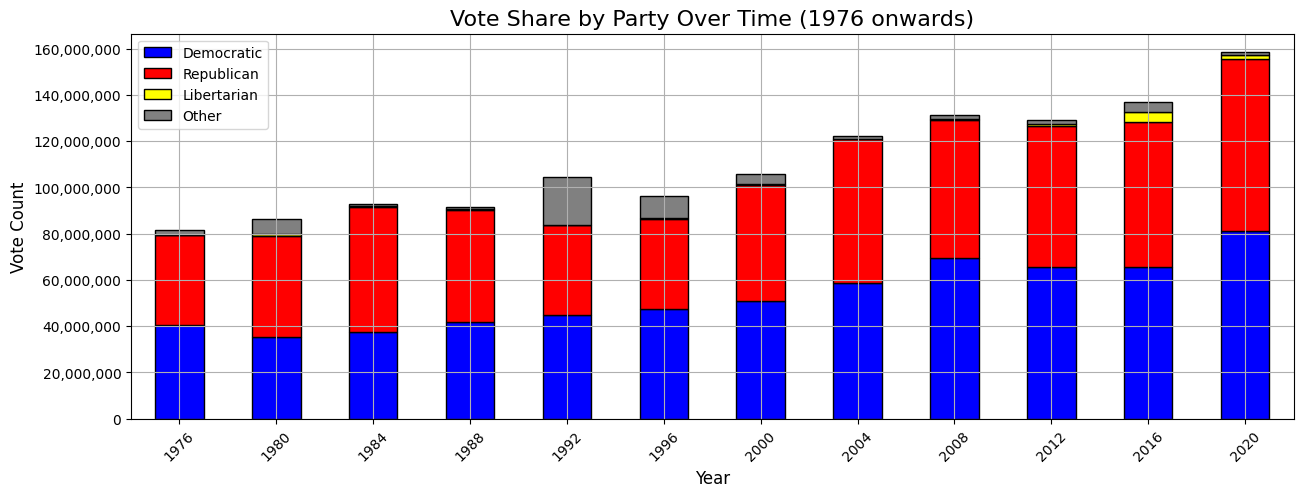

In [5]:
# Now let's plot a stacked bar chart in order to better compare the yearly results
ax = country_voting_year[['Democratic', 'Republican', 'Libertarian', 'Other']].plot.bar(
    stacked=True, figsize=(15, 5), color=[party_color_map['Democratic'], party_color_map['Republican'],
           party_color_map['Libertarian'], party_color_map['Other']], edgecolor='black'
)

ax.set_xticklabels(country_voting_year['Year'], rotation=45)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Adding title and labels
ax.set_title('Vote Share by Party Over Time (1976 onwards)', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Vote Count', fontsize=12)

# Display the plot
plt.grid(True)
plt.show()

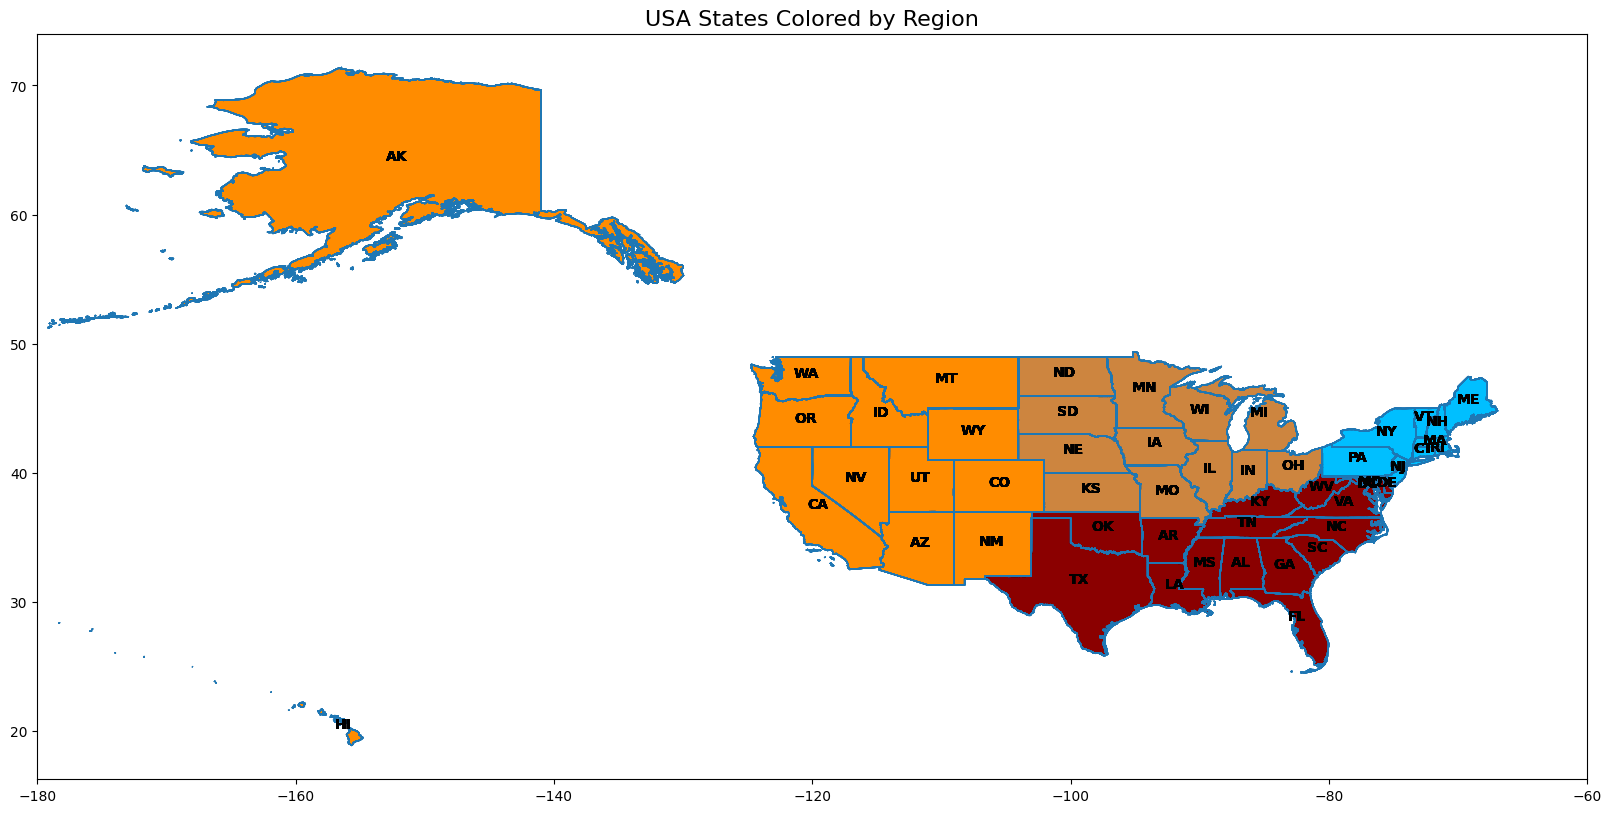

In [6]:
import geopandas as gpd

country_voting['State Initials'] = country_voting['State Initials'].str.upper()  # Ensure all are uppercase

# Read the shapefile
shapefile_path = "/content/drive/MyDrive/CP project/Project/Cleaned Datasets/cb_2020_us_state_500k.shp"
gdf = gpd.read_file(shapefile_path)

# In order to match the States we need to make sure that in both data the State initials (in this case STUSPS) are in upper
gdf['STUSPS'] = gdf['STUSPS'].str.upper()

# Filter the shapefile to only include states in the 'country_voting' DataFrame
valid_states = country_voting['State Initials'].unique()  # this is a list of valid state initials
gdf_filtered = gdf[gdf['STUSPS'].isin(valid_states)]

# Merge the voting data with the filtered shapefile and set index with STUSPS (State Initials)
gdf_filtered = gdf_filtered.set_index('STUSPS')
country_voting_map = country_voting.set_index('State Initials')  # Set state initials in voting data as index
maps = gdf_filtered.join(country_voting_map, how='left')




fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# This allows us to plot the state boundaries
maps.boundary.plot(ax=ax, linewidth=1)

# Use the previouly defined region_color_map
maps.plot(ax=ax, color=maps['Region'].map(region_color_map))

# Set the x-axis limits from -180 to -60 in order to focus on the usa map
ax.set_xlim([-180, -60])

# Now let's add state initials to the map in the center of each state
for x, y, label in zip(maps.geometry.centroid.x, maps.geometry.centroid.y, maps.index):
    ax.text(x, y, label, fontsize=10, ha='center', color='black', fontweight='bold')

# Add a title and show the plot
plt.title('USA States Colored by Region', fontsize=16)
plt.show()

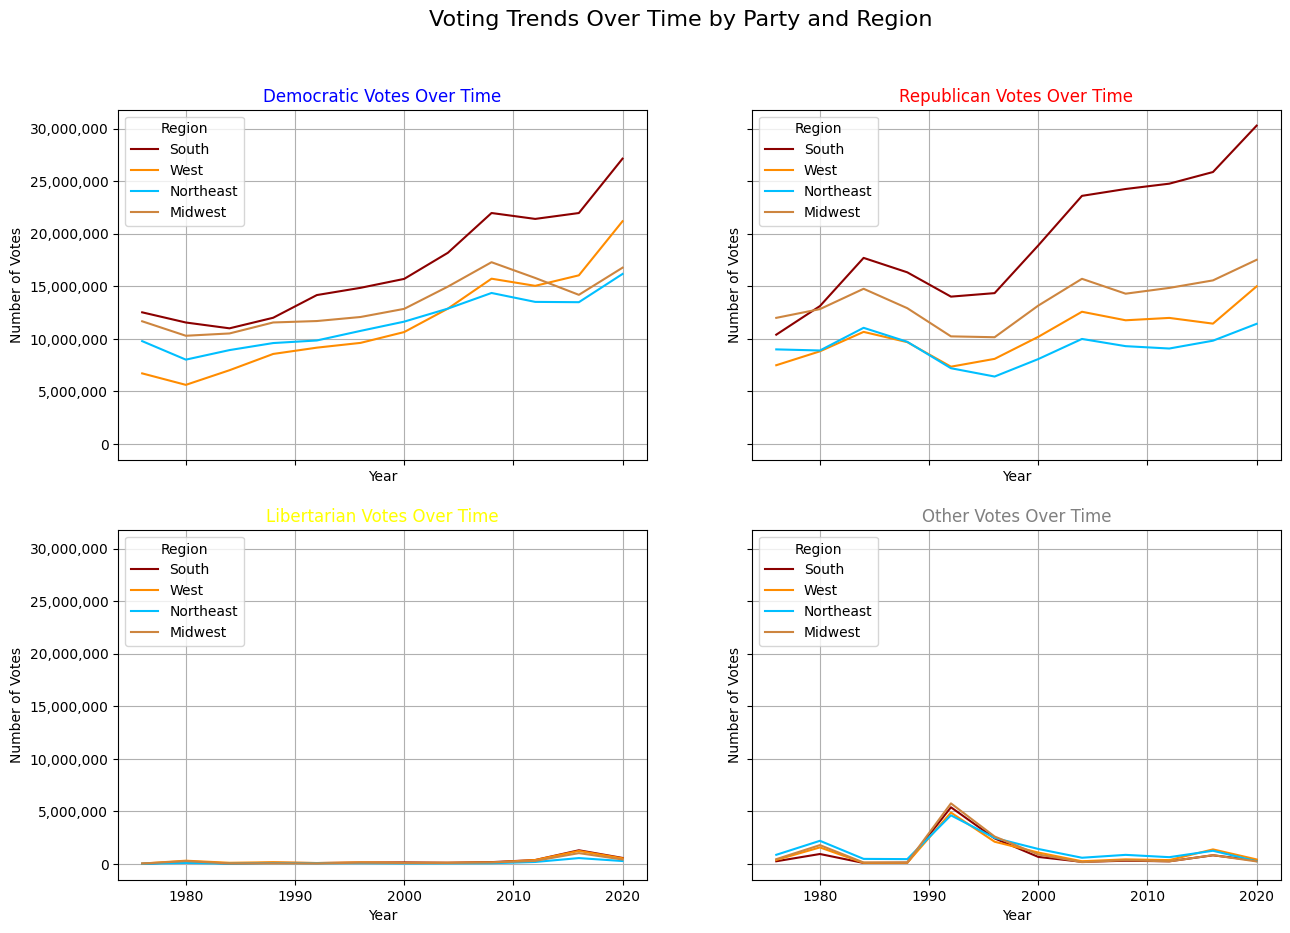

In [7]:
# Let's analyze the voting distributions by creating 4 different subplots, one for each Party, and divide the votes based on previously defined Regions
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("Voting Trends Over Time by Party and Region", fontsize=16)

# Loop through each party and plot its trend for each region. We need to flatten the axes in order to interate over them
axes = axes.flatten()
parties = ['Democratic', 'Republican', 'Libertarian', 'Other']

for i, party in enumerate(parties):
    ax = axes[i]


    # While looping for each party, let's sub-loop for each region
    for j, region in enumerate(country_voting['Region'].unique()):
        # Filter data for the region and group by year
        region_data = country_voting[country_voting['Region'] == region].groupby('Year')[party].sum()
        # And then plot data with the specified region color
        ax.plot(region_data.index, region_data.values, label=region, color=region_color_map[region])

    # Set titles and labels inside the party loop since we need to create one for each graph

    ax.set_title(f"{party} Votes Over Time", color=party_color_map[party])
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of Votes")
    ax.legend(title="Region", loc="upper left")
    # Prevent scientific notation on the y-axis and implement grid for each subplot
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
    ax.grid(True)



# Show the plot
plt.show()

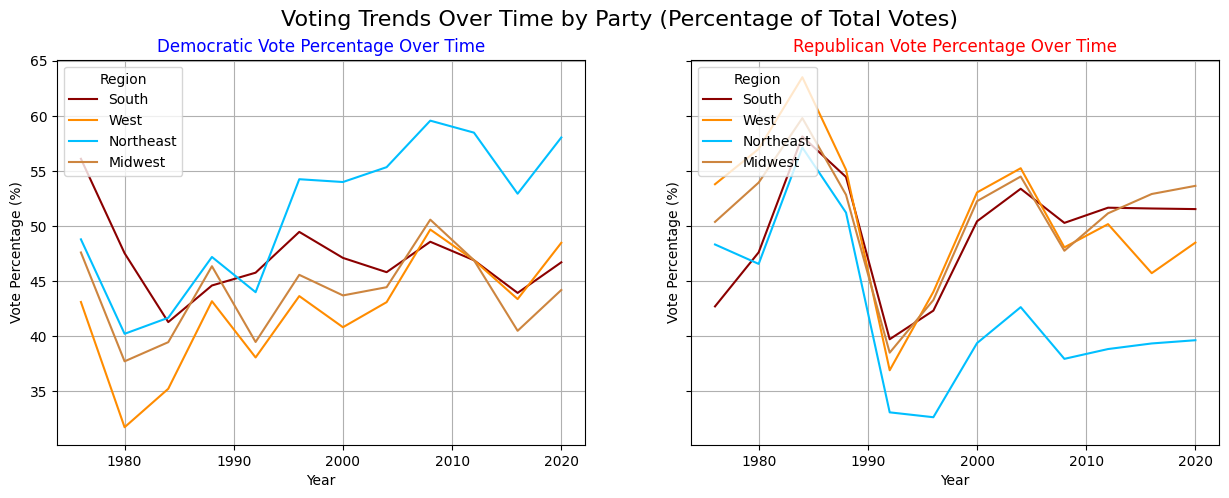

In [8]:
# Let's concentrate on the most important parties : Democratic & Republican
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle("Voting Trends Over Time by Party (Percentage of Total Votes)", fontsize=16)

# Loop through each party and plot its trend for each region
axes = axes.flatten()
parties = ['Democratic', 'Republican']
for i, party in enumerate(parties):
    ax = axes[i]

     # Now loop through each region (unique) to plot trends for this party
    for j, region in enumerate(country_voting['Region'].unique()):
        # Filter data for the region
        region_data = country_voting[country_voting['Region'] == region].copy()

        # To have a better understanding, let's use the % and not the absolutes votes. Let's create a new variable that will contain the total amount of votes
        region_data['TotalVotes'] = region_data['Democratic'] + region_data['Republican'] + region_data['Libertarian'] + region_data['Other']
        region_data[f"{party}_percentage"] = region_data[party] / region_data['TotalVotes'] * 100

        # Group by Year and plot the percentage of votes for the partym and then plot
        region_data_grouped = region_data.groupby('Year')[f"{party}_percentage"].mean()
        ax.plot(region_data_grouped.index, region_data_grouped.values, label=region, color=region_color_map[region])

    # Set titles and labels inside the loop and use the region color map
    ax.set_title(f"{party} Vote Percentage Over Time", color=party_color_map[party]) # Apply region color to title
    ax.set_xlabel("Year")
    ax.set_ylabel("Vote Percentage (%)")
    ax.legend(title="Region", loc="upper left")
    ax.grid(True)



# Show the plot

plt.show()

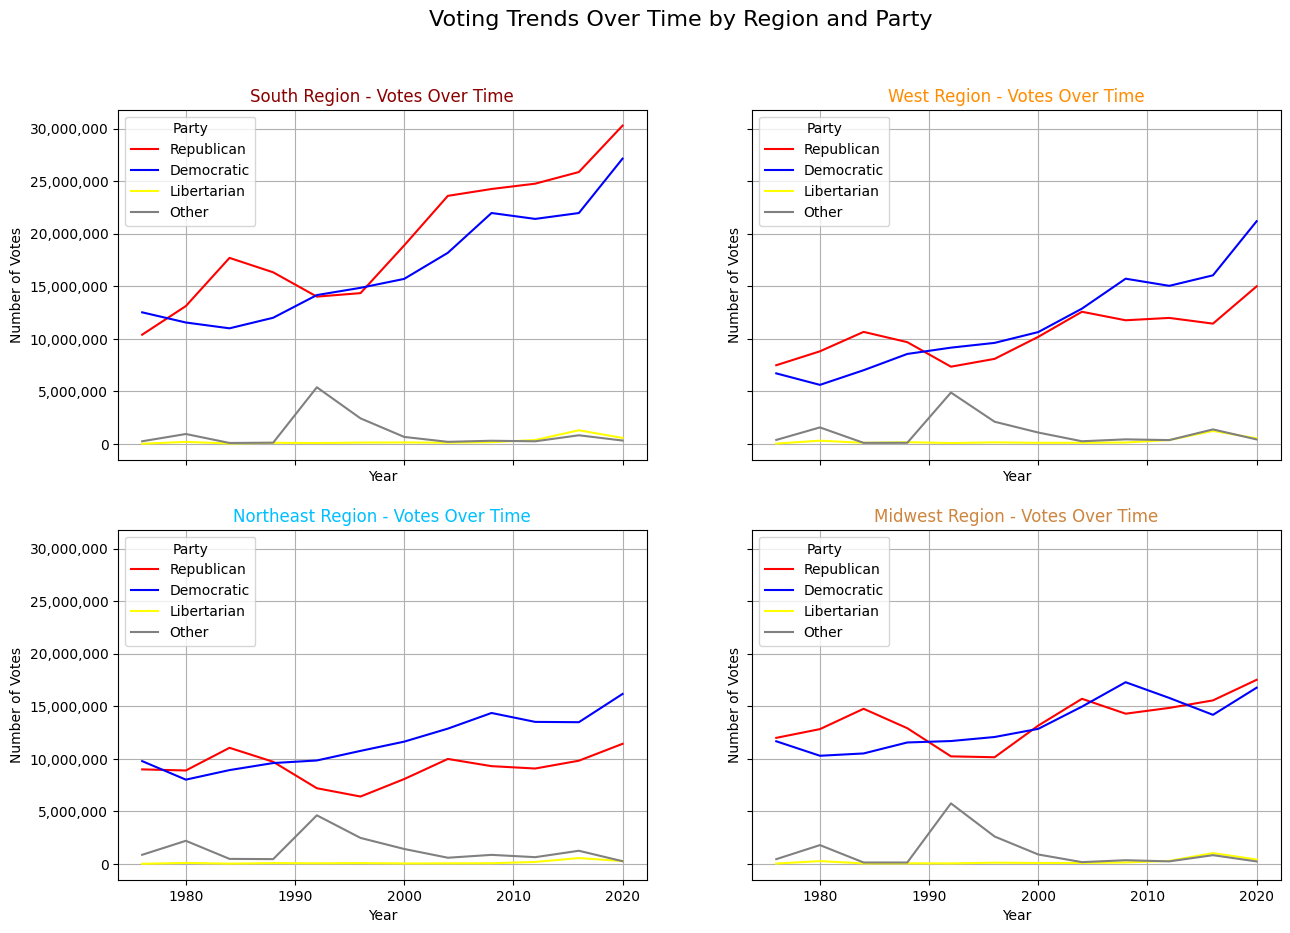

In [9]:
# Let's now analyze the voting trends based on the regions. Create a grid for 4 different subplots, one for each region
regions = country_voting['Region'].unique()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle("Voting Trends Over Time by Region and Party", fontsize=16)
axes = axes.flatten()



# Loop through each region and create a subplot for it
for i, region in enumerate(regions):
    ax = axes[i]  # ax access the subplot
    # Iterate, filter the data based on the region we are iterating and compute the party sum, then plot
    for party in party_color_map.keys():
      region_data = country_voting[country_voting['Region'] == region].groupby('Year')[party].sum()
      ax.plot(region_data.index, region_data.values, label=party, color=party_color_map[party])

    ax.set_title(f"{region} Region - Votes Over Time", color=region_color_map[region])
    ax.set_xlabel("Year")
    ax.grid(True)
    ax.set_ylabel("Number of Votes")
    ax.legend(title="Party", loc="upper left")
    ax.grid(True)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.show()

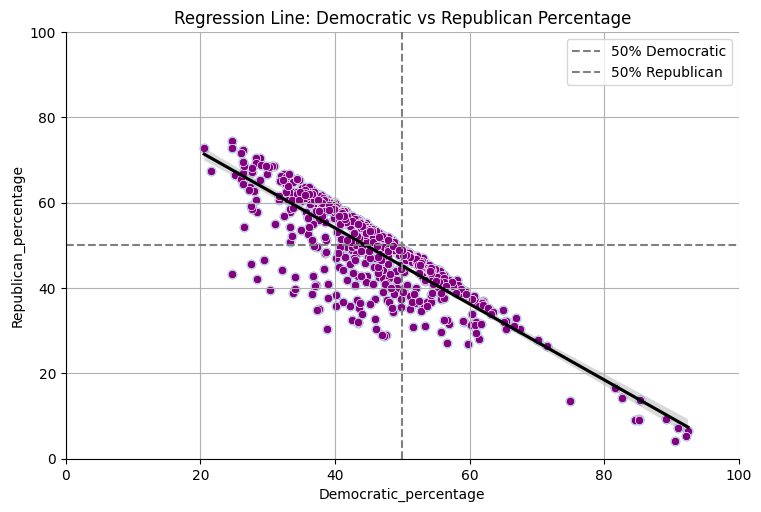

Covariance between Democratic and Republican Percentage: -98.02417790442348
Correlation coefficient between Democratic and Republican Percentage: -0.8376719973975201
Linear Regression Results:
Slope: -0.8901013419990501
Intercept: 89.6706891314009
R-squared: 0.7016943752239511
P-value: 2.2775185618588783e-162
Standard Error: 0.023498019609176697


In [10]:
# We analyzed, and confirmed, that usa presidential elections are a two-party election (only the 1992 election saw a spike in election for the Ross Perot campaign (independent))
# Let's then focus on these 2 parties and create % variables
country_voting['Democratic_percentage'] = country_voting['Democratic'] / (country_voting['Democratic'] + country_voting['Republican'] + country_voting['Libertarian'] + country_voting['Other']) * 100
country_voting['Republican_percentage'] = country_voting['Republican'] / (country_voting['Democratic'] + country_voting['Republican'] + country_voting['Libertarian'] + country_voting['Other']) * 100


# Compute a linear regression between the 2 parties %. We expect to find a clear indirect relationship.
sns.lmplot(x='Democratic_percentage', y='Republican_percentage', data=country_voting, aspect=1.5, line_kws={'color': 'black'})
plt.title('Regression Line: Democratic vs Republican Percentage')

# Set axis limits to be from 0 to 100 otherwise the graph may seem skewed graphically speaking
plt.xlim(0, 100)
plt.ylim(0, 100)

# add dotted lines to show the 50% mark
plt.axvline(x=50, color='grey', linestyle='--', label='50% Democratic')
plt.axhline(y=50, color='grey', linestyle='--', label='50% Republican')

sns.scatterplot(x='Democratic_percentage', y='Republican_percentage', data=country_voting, color='purple')
plt.legend()
plt.grid(True)
plt.show()

# Let's additionally compute some statistical values, the covariance the correlation and the results of the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    country_voting['Democratic_percentage'], country_voting['Republican_percentage']
)

covariance = np.cov(country_voting['Democratic_percentage'], country_voting['Republican_percentage'])[0, 1]
print(f"Covariance between Democratic and Republican Percentage: {covariance}")

correlation = np.corrcoef(country_voting['Democratic_percentage'], country_voting['Republican_percentage'])[0, 1]
print(f"Correlation coefficient between Democratic and Republican Percentage: {correlation}")

print(f"Linear Regression Results:")
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

The negative covariance and strong negative correlation indicate that the performance of the Democratic and Republican parties are inversely related in this dataset.
The linear regression shows a clear linear relationship between the two, with the slope suggesting that as one party's percentage increases, the other's decreases.
The R-squared value of 70.17% suggests that the Democratic percentage explains a significant portion of the variation in the Republican percentage.
The p-value and standard error indicate that the relationship is statistically significant and precise.

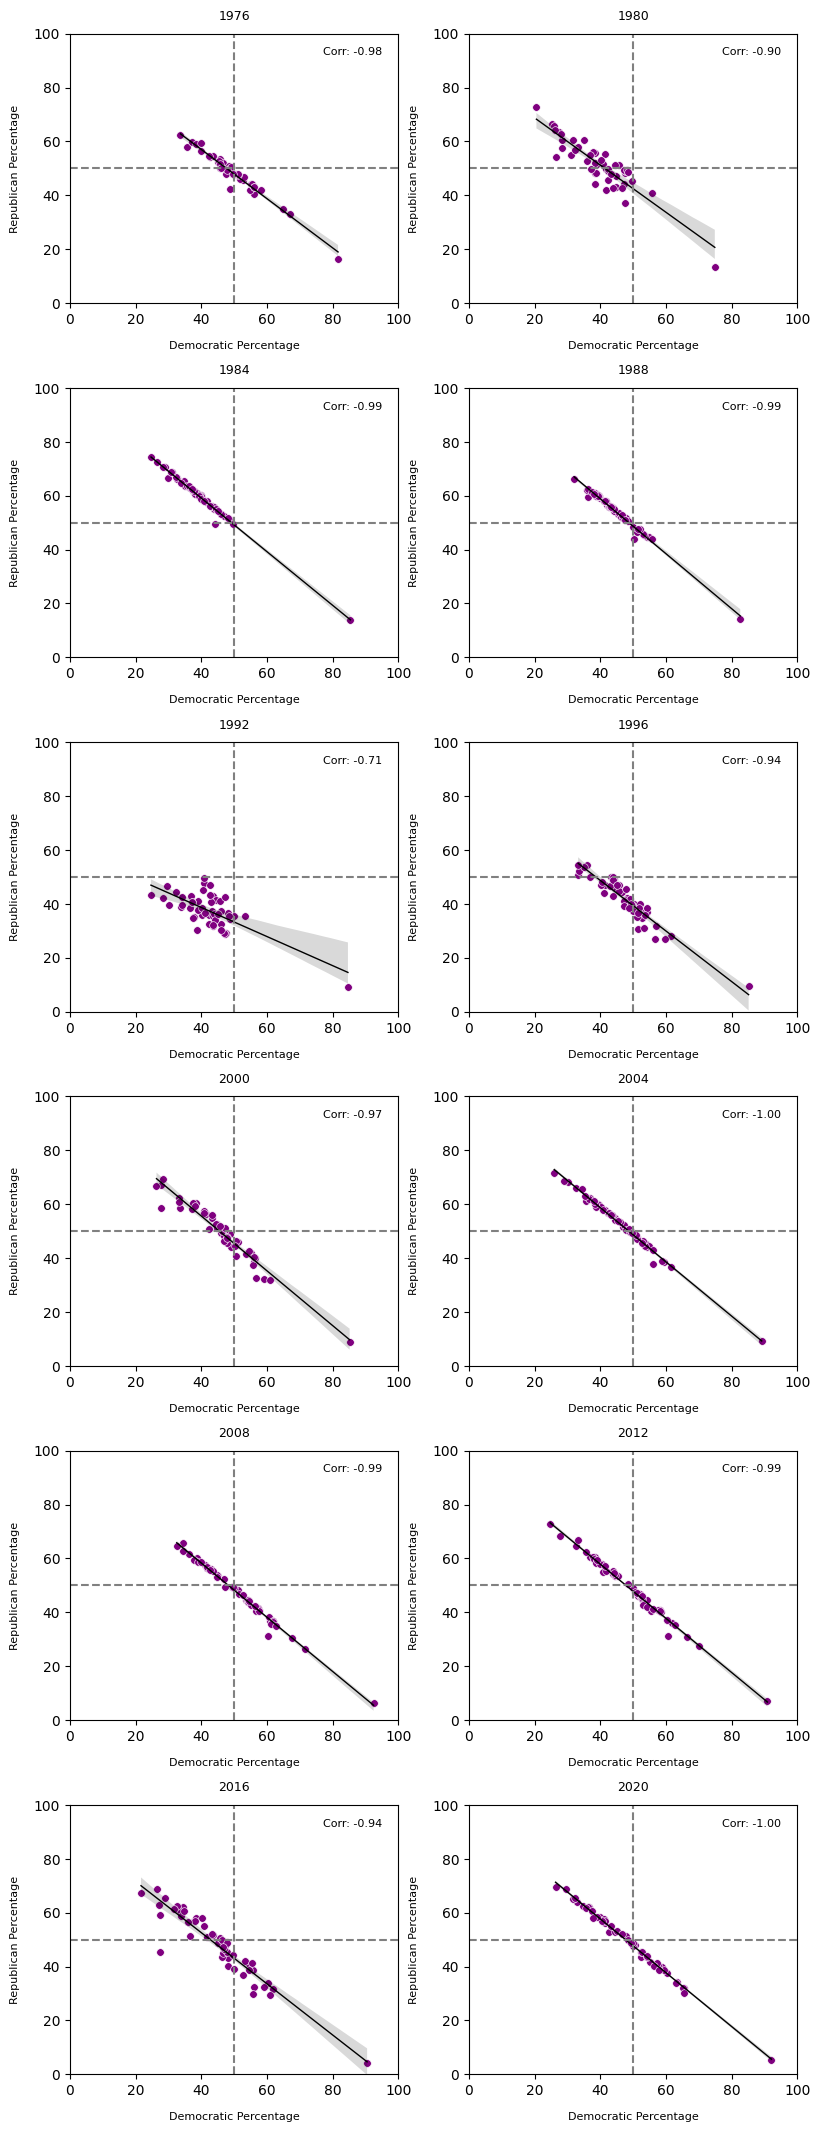

In [11]:
# Let's do the regression for each election year
years = country_voting.index.get_level_values('Year').unique()
n_rows = (len(years) + 1) // 2
n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(8, n_rows * 3.5))
fig.tight_layout(h_pad=4, w_pad=2)  # This adjust space between plots

# iterate over Year variable to create different subplots
for i, year in enumerate(years):
    ax = axes.flatten()[i]
    year_data = country_voting[country_voting.index.get_level_values('Year') == year]

    sns.scatterplot(x='Democratic_percentage', y='Republican_percentage', data=year_data, ax=ax, color='purple', s=30)  # Adjust the point size
    sns.regplot(x='Democratic_percentage', y='Republican_percentage', data=year_data, ax=ax, scatter=False, color='black', line_kws={'linewidth': 1})
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax.axvline(x=50, color='grey', linestyle='--', label='50% Democratic')
    ax.axhline(y=50, color='grey', linestyle='--', label='50% Republican')
    correlation = year_data['Democratic_percentage'].corr(year_data['Republican_percentage'])

    # Add labels, title, and correlation value
    ax.set_title(f'{year}', fontsize=9, pad=10)
    ax.set_xlabel('Democratic Percentage', fontsize=8, labelpad=10)  # Otherwise the x label will overlap
    ax.set_ylabel('Republican Percentage', fontsize=8, labelpad=10)
    ax.text(0.95, 0.95, f'Corr: {correlation:.2f}', transform=ax.transAxes, fontsize=8, color='black', ha='right', va='top')

plt.show()

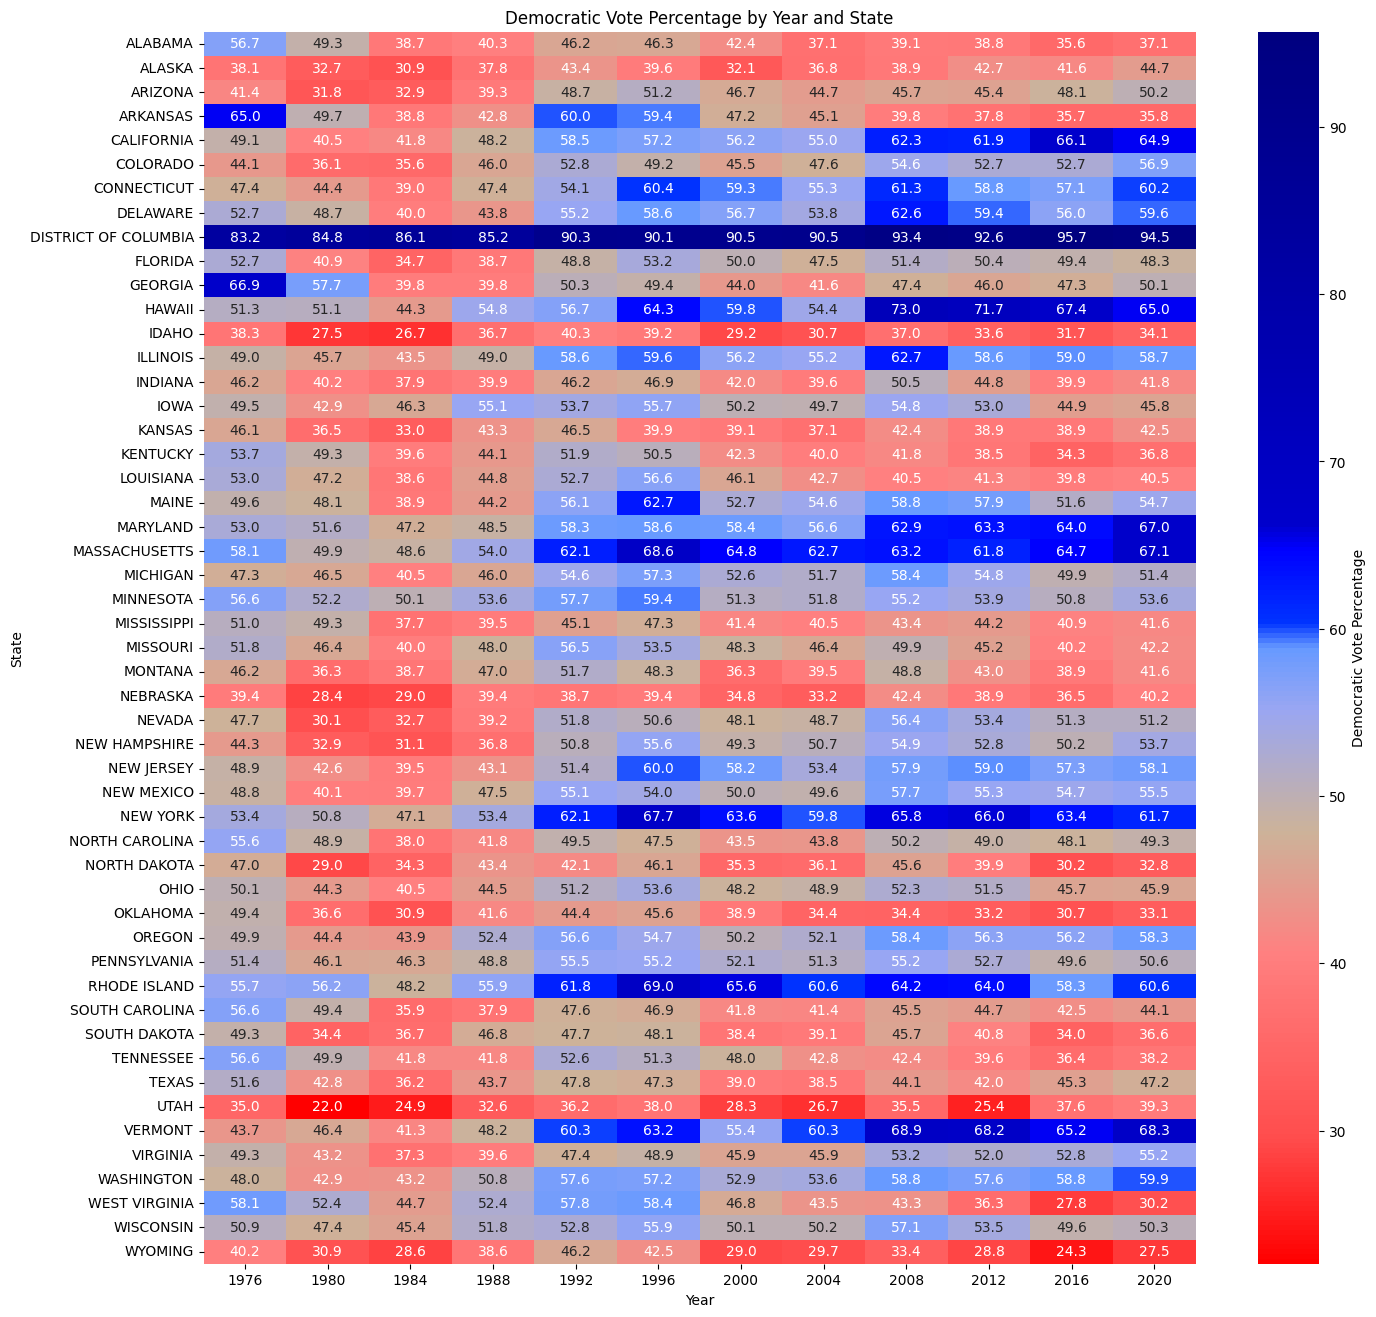

In [12]:
import matplotlib.colors as mcolors
# Create our own colormap.
colors = [
    (1.0, 0.0, 0.0),
    (1.0, 0.3, 0.3),
    (1.0, 0.5, 0.5),
    (0.8, 0.7, 0.6),
    (0.6, 0.65, 0.95),
    (0.4, 0.6, 1.0),
    (0.0, 0.2, 1.0),
    (0.0, 0.1, 1.0),
    (0.0, 0.0, 1.0),
    (0.0, 0.0, 0.8),
    (0.0, 0.0, 0.5)
]

# Define the positions for these colors (with more granular control)
positions = [0.0, 0.1, 0.25, 0.35, 0.45, 0.5, 0.52, 0.55, 0.58, 0.6, 1.0]  # Adjusted to have smoother transitions

# Create a custom colormap
cmap_name = 'gradual_red_white_blue_cmap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, list(zip(positions, colors)))

# Now apply it to the heatmap
heatmap_data = country_voting.copy()  # Create a temporary copy of the original dataset
# Calculate the Democratic and Republican percentages on the fly, without creating new permanent variables
heatmap_data['Democratic_percentage'] = heatmap_data['Democratic'] / (heatmap_data['Democratic'] + heatmap_data['Republican']) * 100
heatmap_data['Republican_percentage'] = heatmap_data['Republican'] / (heatmap_data['Democratic'] + heatmap_data['Republican']) * 100

# Pivot the data for a heatmap representation
heatmap_data = heatmap_data.pivot_table(index='State', columns='Year', values='Democratic_percentage')

# Plot the heatmap with the colormap that we created
plt.figure(figsize=(16, 16))
sns.heatmap(heatmap_data, cmap=custom_cmap, annot=True, fmt=".1f", cbar_kws={'label': 'Democratic Vote Percentage'})
plt.title("Democratic Vote Percentage by Year and State")
plt.xlabel('Year')
plt.ylabel('State')
plt.show()

In [13]:
country_voting.loc[pd.IndexSlice[:, 'DISTRICT OF COLUMBIA'], :]

,,State Initials,Democratic,Libertarian,Other,Republican,Region,Winner,Democratic_percentage,Republican_percentage
Year,State,,,,,,,,,
1976,DISTRICT OF COLUMBIA,DC,137818,0,3139,27873,South,Democratic,81.631227,16.509507
1980,DISTRICT OF COLUMBIA,DC,130231,1104,19241,23313,South,Democratic,74.893179,13.406828
1984,DISTRICT OF COLUMBIA,DC,180408,279,1592,29009,South,Democratic,85.384878,13.729601
1988,DISTRICT OF COLUMBIA,DC,159407,554,5326,27590,South,Democratic,82.646972,14.304453
1992,DISTRICT OF COLUMBIA,DC,192619,467,13788,20698,South,Democratic,84.640905,9.095144
1996,DISTRICT OF COLUMBIA,DC,158220,588,9579,17339,South,Democratic,85.190011,9.335796
2000,DISTRICT OF COLUMBIA,DC,171923,669,11229,18073,South,Democratic,85.155081,8.951727
2004,DISTRICT OF COLUMBIA,DC,202970,502,2858,21256,South,Democratic,89.183869,9.339766
2008,DISTRICT OF COLUMBIA,DC,245800,0,2686,17367,South,Democratic,92.457110,6.532557


In [14]:
country_voting.loc[pd.IndexSlice[:, 'UTAH'], :]

,,State Initials,Democratic,Libertarian,Other,Republican,Region,Winner,Democratic_percentage,Republican_percentage
Year,State,,,,,,,,,
1976,UTAH,UT,182110,0,21200,337908,West,Republican,33.648179,62.434731
1980,UTAH,UT,124266,7156,33043,439687,West,Republican,20.568665,72.777546
1984,UTAH,UT,155369,2447,2735,469105,West,Republican,24.675219,74.501791
1988,UTAH,UT,207343,7473,3750,428442,West,Republican,32.046435,66.218965
1992,UTAH,UT,183429,1900,236037,322632,West,Republican,24.654502,43.364633
1996,UTAH,UT,221633,4129,77956,361911,West,Republican,33.296776,54.371279
2000,UTAH,UT,203053,3616,48989,515096,West,Republican,26.344722,66.830143
2004,UTAH,UT,241199,3375,19528,663742,West,Republican,25.995642,71.535948
2008,UTAH,UT,327670,6966,21704,596030,West,Republican,34.405746,62.583870


State
ARKANSAS         30.186666
WEST VIRGINIA    28.372997
VERMONT          23.151727
ALABAMA          19.157279
TENNESSEE        18.489314
GEORGIA          17.465239
KENTUCKY         16.602734
OKLAHOMA         16.461046
CALIFORNIA       15.529125
NORTH DAKOTA     14.013281
Name: Democratic_percentage, dtype: float64


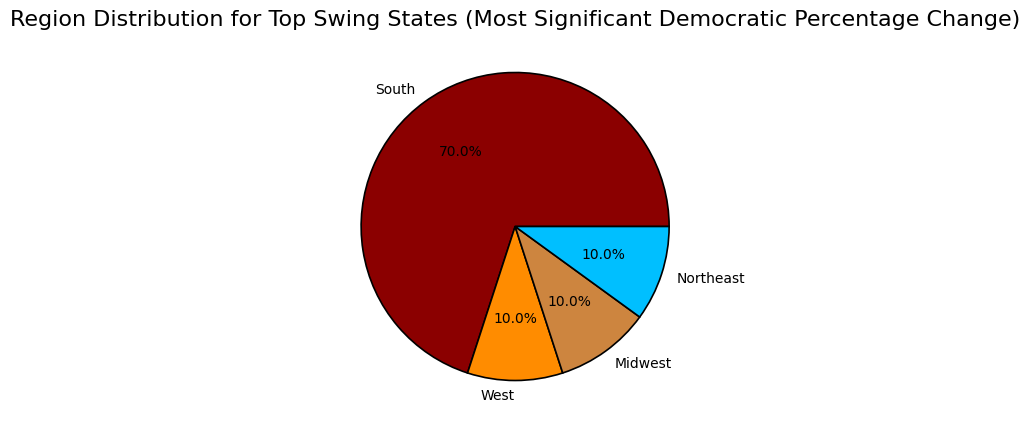

In [15]:
# Compute the 'top_swingers' states. The states that, from 1976 to 2020, recorded the biggest difference in voting percentage-
# The labda function allows to compute the difference between the last element, xiloc[-1], and the first, xiloc[0]
democratic_change = country_voting.groupby('State')['Democratic_percentage'].agg(lambda x: x.iloc[-1] - x.iloc[0])
democratic_change = democratic_change.abs().sort_values(ascending=False)
# The top 10 states with the most significant shifts
top_swing_states = democratic_change.head(10)
print(top_swing_states)

# Study the regions of these top 10 states
top_swing_state_names = top_swing_states.head(10).index  # Get the top 10 states with the largest change
top_swing_states_data = country_voting[country_voting.index.get_level_values('State').isin(top_swing_state_names)]
region_distribution = top_swing_states_data['Region'].value_counts()

# Represent this using a Pie plot
plt.pie(region_distribution, labels=region_distribution.index, autopct='%1.1f%%',
        colors=[region_color_map[region] for region in region_distribution.index],
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.2, 'linestyle': 'solid'})
plt.title('Region Distribution for Top Swing States (Most Significant Democratic Percentage Change)', fontsize=16)
plt.show()


,Democratic_percentage_change,Transition
State,,
ALABAMA,"(55.727268884473936, 36.569990212122335)",Democratic to Republican
ARKANSAS,"(64.96172812966185, 34.77506195301496)",Democratic to Republican
CALIFORNIA,"(47.954821836112544, 63.48394689387351)",Republican to Democratic
COLORADO,"(42.60994599792869, 55.01106714065329)",Republican to Democratic
CONNECTICUT,"(46.733700964038796, 59.26073151568352)",Republican to Democratic
FLORIDA,"(51.92610623078361, 47.86145072544223)",Democratic to Republican
GEORGIA,"(66.93829485931741, 49.473055784446274)",Democratic to Republican
ILLINOIS,"(48.107590268914244, 57.54164537667581)",Republican to Democratic
KENTUCKY,"(52.75424926872652, 36.15151481115404)",Democratic to Republican


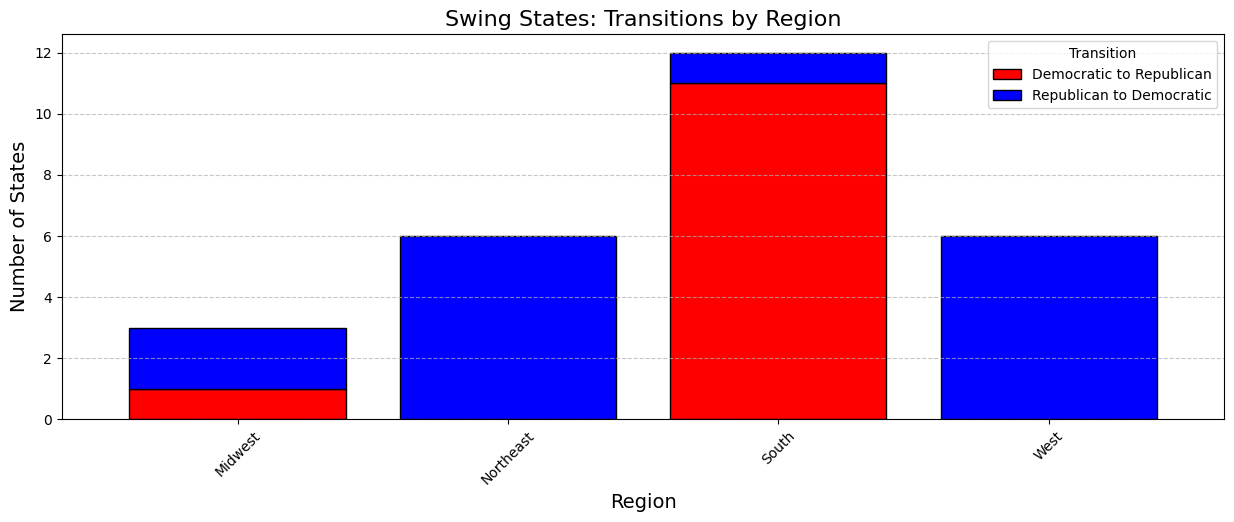

In [16]:
# A more insightful analysis would involve examining whether states crossed the 50% threshold, indicating a shift from one party to another.

# Identify Swing States (those that crossed the 50% threshold for Democratic percentage)
def identify_swing_states(df):
    democratic_percentage_change = df.groupby('State')['Democratic_percentage'].agg(lambda x: (x.iloc[0], x.iloc[-1]))
    # Now we need to filter only if they have crossed the threshold, one way or the other
    swing_states = democratic_percentage_change[democratic_percentage_change.apply(
        lambda x: (x[0] > 50 > x[1]) or (x[0] < 50 < x[1]))]
    return swing_states

# This function adds transition type (Democratic to Republican, Republican to Democratic)
def get_transition_type(row):
    if row[0] > 50 and row[1] < 50:
        return 'Democratic to Republican'
    elif row[0] < 50 and row[1] > 50:
        return 'Republican to Democratic'
    return 'No significant transition'

# Apply the two defined functions: first, to determine if a state changed its majority party, and then to identify whether the shift was from Democratic to Republican or vice versa.
swing_states = identify_swing_states(country_voting)
transition_type = swing_states.apply(get_transition_type)
swing_states = swing_states.to_frame('Democratic_percentage_change')
swing_states['Transition'] = transition_type
display(swing_states)

# Extract regions for these swing states
swing_states_regions = country_voting[country_voting.index.get_level_values('State').isin(swing_states.index)]
swing_states_regions = swing_states_regions[['Region']]
swing_states_with_region = swing_states.join(swing_states_regions)

# Group by region and count the number of states (size), removing duplicates to ensure states are not counted multiple times
swing_states_with_region_reset = swing_states_with_region.reset_index()
swing_states_with_region_unique = swing_states_with_region_reset.drop_duplicates(subset=['State', 'Region'])
region_transition_counts = swing_states_with_region_unique.groupby(['Region', 'Transition']).size().unstack(fill_value=0)

# Plot the bar chart
region_transition_counts.plot(kind='bar', stacked=True, color=['red', 'blue'], width=0.8, edgecolor='black')
plt.title('Swing States: Transitions by Region', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Number of States', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Transition', labels=['Democratic to Republican', 'Republican to Democratic'])

plt.show()



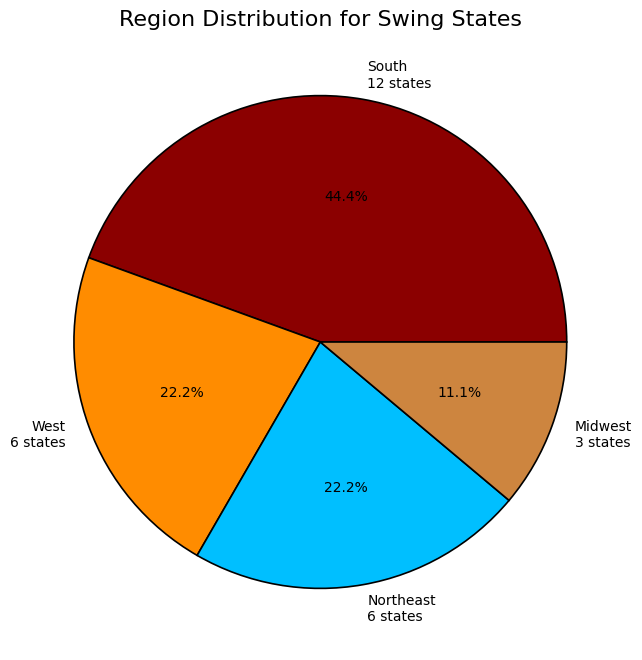

In [17]:
# Pie Chart for Region Distribution of Swing States
swing_states_regions = swing_states_with_region_unique['Region'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(swing_states_regions,
        labels=[f'{region}\n{count} states' for region, count in zip(swing_states_regions.index, swing_states_regions)],
        colors=[region_color_map[region] for region in swing_states_regions.index],
        autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.2, 'linestyle': 'solid'})

plt.title('Region Distribution for Swing States', fontsize=16)
plt.show()